<p style="font-weight:bold; letter-spacing: 2px; color:#F5F5DC; font-size:140%; text-align:left; max-width: 1050px; padding: 10px; border-bottom: 3px solid #D2B48C"> AdaBoost Classification</p>

*Import Libraries*

In [2]:
# import custom classes, functions and variables. Reload file in to memory on cell excution.
import importlib
import settings
importlib.reload(settings)

# import data frameworks
import pandas as pd
import numpy as np

# import viz
import matplotlib.pyplot as plt
import seaborn as sns

# import ML
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC


# import others
import os
import pickle
import warnings

# Specific warning categories to be ignored
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

*Approach*
1. Load data
2. Split data
3. Create ColumnTransformer w/ ohe (so scaling needed)
4. Create AdaBoostClassifier w/ default
5. Create pipeline w/ ColumnTransformer & AdaBoostClassifier
6. Create and evaluate cross_val_score on pipeline
7. Compare train and test scores for baseline model (overfitting? Train likely ~ 100%)
8. Compare affect of different seeds on baseline model. Verify cross_val_score and test averages are similar
9. Create GridSearchCV with params 
10. Fit and evaluate best hyperparameters
11. Plot classification_report and confusion_matrix
12. Evaluate affect of balancing the class with smote or with class_weight="balanced" 
14. ???Select k most important features and evaluate re-run with just those


*Import data from initial EDA*

In [3]:
df = pd.read_csv(os.path.join(settings.DATA_EDA_DIR, settings.DATA_EDA_FILE), sep=",")
if len(df) > 0:
    print("df loaded")

df loaded


*Split data and prepare labels*

In [4]:
ALL_FEATURES = ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 
                'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 
                'Daily Steps', 'Blood Pressure Category']
X = df[ALL_FEATURES]
y = df[settings.LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

# check new values in consolidated column
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])

# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

*Preprocess steps*

In [5]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns)
    ],
    remainder='passthrough')

transformed_X_train_array = column_trans.fit_transform(X_train)
transformed_X_test_array = column_trans.transform(X_test)

# Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# Check ohe and scaled datasets
display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

'train: check for dummy encoded columns and scaled values (mean 0 and std 1)'

(261, 23)

,Gender_Female,Gender_Male,Occupation_Accountant,Occupation_Doctor,Occupation_Engineer,Occupation_Lawyer,Occupation_Nurse,Occupation_Salesperson,Occupation_Teacher,Occupation_Unknown,BMI Category_Normal,BMI Category_Overweight,Blood Pressure Category_Elevated,Blood Pressure Category_High Blood Pressure Stage 1,Blood Pressure Category_High Blood Pressure Stage 2,Blood Pressure Category_Normal,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
mean,0.494253,0.505747,0.103448,0.183908,0.176245,0.126437,0.183908,0.084291,0.111111,0.030651,0.582375,0.417625,0.318008,0.375479,0.187739,0.118774,42.145594,7.135249,7.298851,59.996169,5.409962,70.122605,6868.582375
std,0.500928,0.500928,0.305129,0.388153,0.381761,0.332979,0.388153,0.278358,0.314873,0.172702,0.494115,0.494115,0.466597,0.485177,0.391254,0.324144,8.520669,0.784797,1.187579,20.718163,1.746573,4.044025,1621.398228


'test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)'

(113, 23)

,Gender_Female,Gender_Male,Occupation_Accountant,Occupation_Doctor,Occupation_Engineer,Occupation_Lawyer,Occupation_Nurse,Occupation_Salesperson,Occupation_Teacher,Occupation_Unknown,BMI Category_Normal,BMI Category_Overweight,Blood Pressure Category_Elevated,Blood Pressure Category_High Blood Pressure Stage 1,Blood Pressure Category_High Blood Pressure Stage 2,Blood Pressure Category_Normal,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
mean,0.495575,0.504425,0.088496,0.203540,0.150442,0.123894,0.221239,0.088496,0.097345,0.026549,0.566372,0.433628,0.353982,0.345133,0.212389,0.088496,42.274336,7.124779,7.345133,57.265487,5.327434,70.265487,6697.345133
std,0.502208,0.502208,0.285279,0.404424,0.359097,0.330928,0.416930,0.285279,0.297748,0.161476,0.497783,0.497783,0.480334,0.477529,0.410821,0.285279,9.053657,0.823704,1.223066,21.057327,1.844115,4.356886,1610.648726


*Create pipeline and base model*

In [6]:
# create weak learner
model_dt = DecisionTreeClassifier(random_state=42, max_depth=1)

# create adaboost model
model_ada = AdaBoostClassifier(random_state=42, base_estimator = model_dt)

#create sklearn pipeline
pipeline_ada = settings.create_pipeline(["preprocess", column_trans], ["adaboost", model_ada])

# create cross validation object for cross_val_score
cv_ada = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# define custom scorer for this work: positive label (class 1 and 2) F1 score
base_scorer = settings.CustomPositiveF1Scorer().scorer_function
custom_scorer = settings.CustomPositiveF1Scorer().custom_scorer

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_ada, X_train, y_train, scoring=custom_scorer, cv=cv_ada)

settings.cross_val_summary(pipeline_ada, cv_scores, X_train, y_train, X_test, y_test, scorer=base_scorer)


Train Score: 62.555 %
Mean CV Train Score: 61.7648 % ( +- 14.852 % )
Test Score: 63.462 %



Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.70      0.75        66
           1       0.56      0.58      0.57        24
           2       0.59      0.83      0.69        23

    accuracy                           0.70       113
   macro avg       0.66      0.70      0.67       113
weighted avg       0.72      0.70      0.70       113



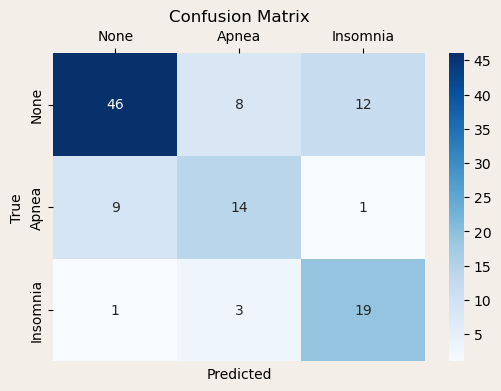

In [7]:
pipeline_ada.fit(X_train, y_train)

# Generate prediction and show classification report
y_pred = pipeline_ada.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Not very good baseline cross-validated positive-class F1 score at 61.8% and lower test at 63.5%. train score is 62.6% showing all close to eachother: no overfitting and appears to be a high bias.</li>
    <li>Confusion matrix shows issue is misclassifying None as Apnea and Insomnia, reducing significantly their precison. There is also a generally poor ability to separate None and Apnea, reducing Apnea's precision. Recall on Insomnia is high however, and ability to seperate true Apnea and true Insomnia is also on par with the single models.</li>     
</ul>
</div>


In [7]:
# Save baseline pipeline to file  
settings.save_pipeline("best_adaboost_classification_pipeline.pkl", pipeline_ada)

*Hyperparam tuning*

In [8]:
# set up param grid
param_grid_ada = {
    'adaboost__base_estimator__max_depth': [1, 2, 3, 4, 5],
    'adaboost__n_estimators': [14, 16, 18, 20, 22],
    'adaboost__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
}

# Create and fit GridSearchCV object on train data
grid_search_ada = GridSearchCV(pipeline_ada, param_grid=param_grid_ada, scoring=custom_scorer, cv=cv_ada, n_jobs=-1)
grid_search_ada.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_ada, X_train, y_train, X_test, y_test, scorer=base_scorer)

Best Parameters:


,adaboost__base_estimator__max_depth,adaboost__learning_rate,adaboost__n_estimators
0,1,0.1,18


---------------------
Using best parameters
---------------------
Train Score: 83.254 %
Mean CV Train Score: 82.098 % ( +- 6.316 % )
Test Score: 83.871 %


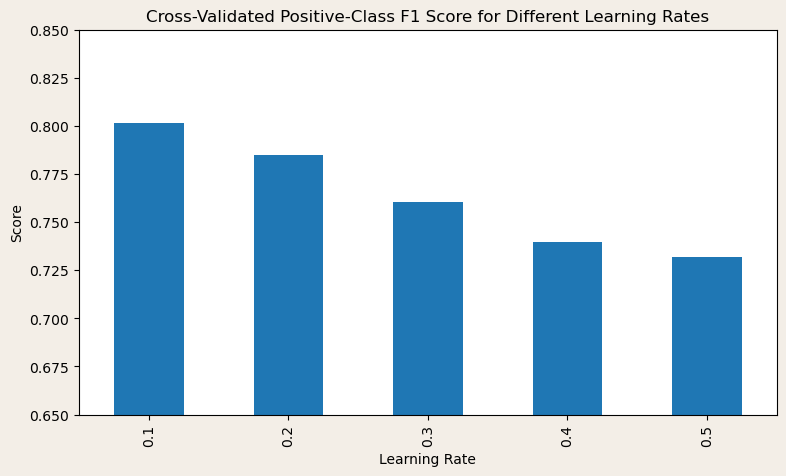

In [10]:
# Access the grid search results
results = grid_search_ada.cv_results_

# Extract k values, weights values and accuracy scores
grouped = pd.DataFrame(results)
grouped = grouped.groupby(["param_adaboost__learning_rate"])["mean_test_score"].mean()

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
grouped.plot(kind='bar', figsize=(9, 5), ax=ax)

# Add plot details
ax.set_ylim(0.65, 0.85)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Score')
ax.set_title('Cross-Validated Positive-Class F1 Score for Different Learning Rates')
plt.show()

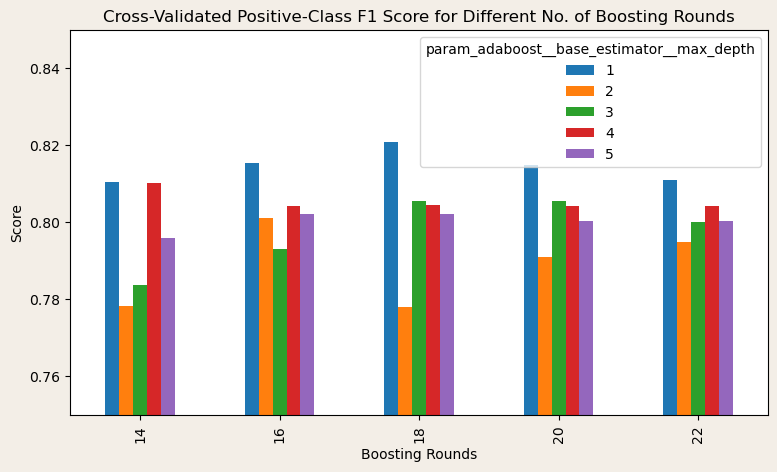

In [11]:
# Access the grid search results
results = grid_search_ada.cv_results_

# Extract k values, weights values and accuracy scores
grouped = pd.DataFrame(results)
grouped = grouped[grouped["param_adaboost__learning_rate"]== 0.1]
grouped = grouped.groupby(["param_adaboost__n_estimators", "param_adaboost__base_estimator__max_depth"])["mean_test_score"].mean().unstack()

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
grouped.plot(kind='bar', figsize=(9, 5), ax=ax)

# Add plot details
ax.set_ylim(0.75, 0.85)
ax.set_xlabel('Boosting Rounds')
ax.set_ylabel('Score')
ax.set_title('Cross-Validated Positive-Class F1 Score for Different No. of Boosting Rounds')
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96        66
           1       0.80      0.83      0.82        24
           2       0.90      0.83      0.86        23

    accuracy                           0.91       113
   macro avg       0.89      0.88      0.88       113
weighted avg       0.91      0.91      0.91       113



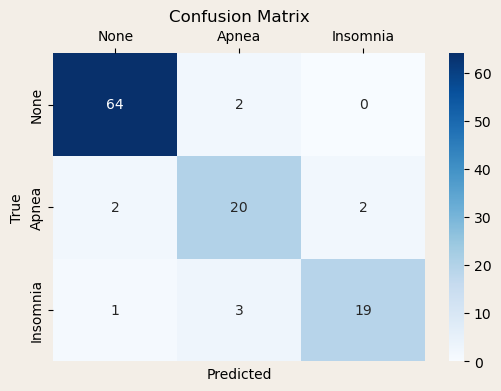

In [12]:
pipeline_ada = grid_search_ada.best_estimator_
pipeline_ada.fit(X_train, y_train)

# Generate prediction and show classification report
y_pred = pipeline_ada.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Hyperparam tuning improves results greatly.</li>
    <li>Cross validated F1 score decreases consistently after a learning rate of 0.1</li>
    <li>18 boosting rounds produces the best score when performed on a decision stump (depth of 1).</li>
    <li>Confusion matrix shows much improved separation of the classes. This remains, however, below the scores of simplier models such as Logisitic Regression and KNN.</li>     
</ul>
</div>


*Change of weak learners: Logistic regression and Naive Bayes. KNN does not support sample_weights* 

*Logistic Regression*

In [13]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns),
        ('scale', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns)
    ],
    remainder='passthrough')

transformed_X_train_array = column_trans.fit_transform(X_train)
transformed_X_test_array = column_trans.transform(X_test)

# Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# # Check ohe and scaled datasets
# display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
# display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

In [40]:
from sklearn.linear_model import LogisticRegression

# create weak learner
model_mlr = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)

# create adaboost model
model_ada = AdaBoostClassifier(random_state=42, base_estimator = model_mlr)

#create sklearn pipeline
pipeline_ada = settings.create_pipeline(["preprocess", column_trans], ["adaboost", model_ada])

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_ada, X_train, y_train, scoring=custom_scorer, cv=cv_ada)

settings.cross_val_summary(pipeline_ada, cv_scores, X_train, y_train, X_test, y_test, scorer=base_scorer)


Train Score: 87.324 %
Mean CV Train Score: 82.7815 % ( +- 5.733 % )
Test Score: 80.412 %


*Hyperparam tuning*

In [41]:
# set up param grid
param_grid_ada = {
    'adaboost__base_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'adaboost__n_estimators': [14, 16, 18, 20, 22],
    'adaboost__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
}

# Create and fit GridSearchCV object on train data
grid_search_ada = GridSearchCV(pipeline_ada, param_grid=param_grid_ada, scoring=custom_scorer, cv=cv_ada, n_jobs=-1)
grid_search_ada.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_ada, X_train, y_train, X_test, y_test, scorer=base_scorer)

Best Parameters:


,adaboost__base_estimator__C,adaboost__learning_rate,adaboost__n_estimators
0,10,0.2,14


---------------------
Using best parameters
---------------------
Train Score: 87.324 %
Mean CV Train Score: 83.978 % ( +- 6.857 % )
Test Score: 82.105 %


*Naive bayes* 

In [14]:
# SET UP AND VERIFICATION OF TRANSFORMERS STEPS BEFORE PIPELINE

# Create a custom binner for df transform
binner = settings.CustomBinnerNB()

# Transform step 1
binned_X_train_array = binner.fit_transform(X_train)
binned_X_test_array = binner.transform(X_test)

# Retrieve new column names for OneHotEncoder
ALL_FEATURES_BINS = binned_X_train_array.columns 

# Create a column transformer for encoding
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse = False, handle_unknown='ignore'), ALL_FEATURES_BINS)
    ],
    remainder='passthrough')

# Transform step 2
transformed_X_train_array = column_trans.fit_transform(binned_X_train_array)
transformed_X_test_array = column_trans.transform(binned_X_test_array)

# # Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# Check ohe and scaled datasets
display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

'train: check for dummy encoded columns and scaled values (mean 0 and std 1)'

(261, 81)

,Gender_Female,Gender_Male,Occupation_Accountant,Occupation_Doctor,Occupation_Engineer,Occupation_Lawyer,Occupation_Nurse,Occupation_Salesperson,Occupation_Teacher,Occupation_Unknown,Quality of Sleep_4,Quality of Sleep_5,Quality of Sleep_6,Quality of Sleep_7,Quality of Sleep_8,Quality of Sleep_9,Stress Level_3,Stress Level_4,Stress Level_5,Stress Level_6,Stress Level_7,Stress Level_8,BMI Category_Normal,BMI Category_Overweight,Heart Rate_65,Heart Rate_67,Heart Rate_68,Heart Rate_69,Heart Rate_70,Heart Rate_72,Heart Rate_73,Heart Rate_74,Heart Rate_75,Heart Rate_76,Heart Rate_78,Heart Rate_80,Heart Rate_81,Heart Rate_83,Heart Rate_84,Heart Rate_85,Blood Pressure Category_Elevated,Blood Pressure Category_High Blood Pressure Stage 1,Blood Pressure Category_High Blood Pressure Stage 2,Blood Pressure Category_Normal,Age Bin_25-29,Age Bin_30-34,Age Bin_35-39,Age Bin_40-44,Age Bin_45-49,Age Bin_50-54,Age Bin_55-59,Sleep Duration Bin_5.5-5.9,Sleep Duration Bin_6.0-6.4,Sleep Duration Bin_6.5-6.9,Sleep Duration Bin_7.0-7.4,Sleep Duration Bin_7.5-7.9,Sleep Duration Bin_8.0-8.4,Physical Activity Level Bin_20-29,Physical Activity Level Bin_30-39,Physical Activity Level Bin_40-49,Physical Activity Level Bin_50-59,Physical Activity Level Bin_60-69,Physical Activity Level Bin_70-79,Physical Activity Level Bin_80-89,Heart Rate Bin_60-64,Heart Rate Bin_65-69,Heart Rate Bin_70-74,Heart Rate Bin_75-79,Heart Rate Bin_80-84,Daily Steps Bin_3000-3499,Daily Steps Bin_3500-3999,Daily Steps Bin_4000-4499,Daily Steps Bin_4500-4999,Daily Steps Bin_5000-5499,Daily Steps Bin_5500-5999,Daily Steps Bin_6000-6499,Daily Steps Bin_6500-6999,Daily Steps Bin_7000-7499,Daily Steps Bin_7500-7999,Daily Steps Bin_9500-9999,Daily Steps Bin_<3000
mean,0.494253,0.505747,0.103448,0.183908,0.176245,0.126437,0.183908,0.084291,0.111111,0.030651,0.015326,0.019157,0.272031,0.214559,0.302682,0.176245,0.172414,0.195402,0.183908,0.130268,0.134100,0.183908,0.582375,0.417625,0.183908,0.003831,0.241379,0.003831,0.214559,0.176245,0.007663,0.007663,0.103448,0.007663,0.015326,0.007663,0.003831,0.003831,0.007663,0.011494,0.318008,0.375479,0.187739,0.118774,0.084291,0.160920,0.187739,0.287356,0.084291,0.107280,0.088123,0.095785,0.210728,0.103448,0.218391,0.214559,0.157088,0.168582,0.026820,0.199234,0.218391,0.011494,0.180077,0.195402,0.183908,0.463602,0.295019,0.030651,0.026820,0.011494,0.007663,0.003831,0.187739,0.019157,0.183908,0.003831,0.183908,0.011494,0.272031,0.103448,0.011494
std,0.500928,0.500928,0.305129,0.388153,0.381761,0.332979,0.388153,0.278358,0.314873,0.172702,0.123081,0.137340,0.445861,0.411305,0.460301,0.381761,0.378465,0.397272,0.388153,0.337245,0.341414,0.388153,0.494115,0.494115,0.388153,0.061898,0.428742,0.061898,0.411305,0.381761,0.087369,0.087369,0.305129,0.087369,0.123081,0.087369,0.061898,0.061898,0.087369,0.106798,0.466597,0.485177,0.391254,0.324144,0.278358,0.368163,0.391254,0.453399,0.278358,0.310063,0.284018,0.294862,0.408609,0.305129,0.413948,0.411305,0.364583,0.375102,0.161867,0.400192,0.413948,0.106798,0.384990,0.397272,0.388153,0.499631,0.456928,0.172702,0.161867,0.106798,0.087369,0.061898,0.391254,0.137340,0.388153,0.061898,0.388153,0.106798,0.445861,0.305129,0.106798


'test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)'

(113, 81)

,Gender_Female,Gender_Male,Occupation_Accountant,Occupation_Doctor,Occupation_Engineer,Occupation_Lawyer,Occupation_Nurse,Occupation_Salesperson,Occupation_Teacher,Occupation_Unknown,Quality of Sleep_4,Quality of Sleep_5,Quality of Sleep_6,Quality of Sleep_7,Quality of Sleep_8,Quality of Sleep_9,Stress Level_3,Stress Level_4,Stress Level_5,Stress Level_6,Stress Level_7,Stress Level_8,BMI Category_Normal,BMI Category_Overweight,Heart Rate_65,Heart Rate_67,Heart Rate_68,Heart Rate_69,Heart Rate_70,Heart Rate_72,Heart Rate_73,Heart Rate_74,Heart Rate_75,Heart Rate_76,Heart Rate_78,Heart Rate_80,Heart Rate_81,Heart Rate_83,Heart Rate_84,Heart Rate_85,Blood Pressure Category_Elevated,Blood Pressure Category_High Blood Pressure Stage 1,Blood Pressure Category_High Blood Pressure Stage 2,Blood Pressure Category_Normal,Age Bin_25-29,Age Bin_30-34,Age Bin_35-39,Age Bin_40-44,Age Bin_45-49,Age Bin_50-54,Age Bin_55-59,Sleep Duration Bin_5.5-5.9,Sleep Duration Bin_6.0-6.4,Sleep Duration Bin_6.5-6.9,Sleep Duration Bin_7.0-7.4,Sleep Duration Bin_7.5-7.9,Sleep Duration Bin_8.0-8.4,Physical Activity Level Bin_20-29,Physical Activity Level Bin_30-39,Physical Activity Level Bin_40-49,Physical Activity Level Bin_50-59,Physical Activity Level Bin_60-69,Physical Activity Level Bin_70-79,Physical Activity Level Bin_80-89,Heart Rate Bin_60-64,Heart Rate Bin_65-69,Heart Rate Bin_70-74,Heart Rate Bin_75-79,Heart Rate Bin_80-84,Daily Steps Bin_3000-3499,Daily Steps Bin_3500-3999,Daily Steps Bin_4000-4499,Daily Steps Bin_4500-4999,Daily Steps Bin_5000-5499,Daily Steps Bin_5500-5999,Daily Steps Bin_6000-6499,Daily Steps Bin_6500-6999,Daily Steps Bin_7000-7499,Daily Steps Bin_7500-7999,Daily Steps Bin_9500-9999,Daily Steps Bin_<3000
mean,0.495575,0.504425,0.088496,0.203540,0.150442,0.123894,0.221239,0.088496,0.097345,0.026549,0.008850,0.017699,0.300885,0.185841,0.265487,0.221239,0.230088,0.168142,0.168142,0.106195,0.132743,0.194690,0.566372,0.433628,0.168142,0.008850,0.274336,0.008850,0.176991,0.203540,0.0,0.0,0.079646,0.0,0.008850,0.008850,0.008850,0.008850,0.0,0.0,0.353982,0.345133,0.212389,0.088496,0.088496,0.176991,0.194690,0.212389,0.106195,0.132743,0.088496,0.106195,0.265487,0.053097,0.194690,0.230088,0.150442,0.212389,0.044248,0.203540,0.168142,0.017699,0.194690,0.159292,0.168142,0.469027,0.283186,0.035398,0.026549,0.017699,0.026549,0.026549,0.185841,0.008850,0.194690,0.0,0.185841,0.008850,0.265487,0.079646,0.0
std,0.502208,0.502208,0.285279,0.404424,0.359097,0.330928,0.416930,0.285279,0.297748,0.161476,0.094072,0.132443,0.460686,0.390711,0.443559,0.416930,0.422764,0.375658,0.375658,0.309459,0.340809,0.397726,0.497783,0.497783,0.375658,0.094072,0.448167,0.094072,0.383361,0.404424,0.0,0.0,0.271950,0.0,0.094072,0.094072,0.094072,0.094072,0.0,0.0,0.480334,0.477529,0.410821,0.285279,0.285279,0.383361,0.397726,0.410821,0.309459,0.340809,0.285279,0.309459,0.443559,0.225226,0.397726,0.422764,0.359097,0.410821,0.206561,0.404424,0.375658,0.132443,0.397726,0.367578,0.375658,0.501263,0.452553,0.185607,0.161476,0.132443,0.161476,0.161476,0.390711,0.094072,0.397726,0.0,0.390711,0.094072,0.443559,0.271950,0.0


In [15]:
from sklearn.naive_bayes import CategoricalNB

# create model
model_nb = CategoricalNB()

# create adaboost model
model_ada = AdaBoostClassifier(random_state=42, base_estimator = model_nb)

#create sklearn pipeline
pipeline_ada = settings.create_pipeline(["Binner", binner],
                                        ["Preprocess", column_trans], 
                                        ["adaboost", model_ada])

# create cross validation object for cross_val_score
cv_ada = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_ada, X_train, y_train, scoring=custom_scorer, cv=cv_ada)

settings.cross_val_summary(pipeline_ada, cv_scores, X_train, y_train, X_test, y_test, scorer=base_scorer)


Train Score: 51.630 %
Mean CV Train Score: 48.9963 % ( +- 3.864 % )
Test Score: 50.000 %


In [16]:
# set up param grid
param_grid_ada = {
    'adaboost__base_estimator__alpha': [0.1, 0.2, 0.3, 0.4, 0.5],
    'adaboost__n_estimators': [10, 20, 50, 100, 500],
    'adaboost__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
}

# Create and fit GridSearchCV object on train data
grid_search_ada = GridSearchCV(pipeline_ada, param_grid=param_grid_ada, scoring=custom_scorer, cv=cv_ada, n_jobs=-1)
grid_search_ada.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_ada, X_train, y_train, X_test, y_test, scorer=base_scorer)

Best Parameters:


,adaboost__base_estimator__alpha,adaboost__learning_rate,adaboost__n_estimators
0,0.5,0.1,20


---------------------
Using best parameters
---------------------
Train Score: 84.906 %
Mean CV Train Score: 84.032 % ( +- 6.731 % )
Test Score: 87.234 %



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        66
           1       0.81      0.92      0.86        24
           2       0.95      0.83      0.88        23

    accuracy                           0.94       113
   macro avg       0.92      0.91      0.91       113
weighted avg       0.94      0.94      0.94       113



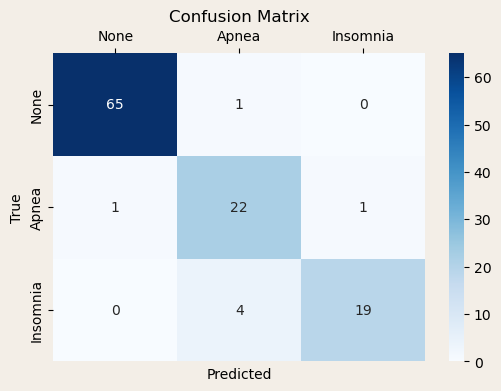

In [17]:
pipeline_ada = grid_search_ada.best_estimator_
pipeline_ada.fit(X_train, y_train)

# Generate prediction and show classification report
y_pred = pipeline_ada.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Best base learner is the Naive Bayes Classifier. Produces an identicle test set score and confusion matrix configuration to the Logistic Regression Model. It is also very similar to the Majority Vote: one more Insomnia sample incorrectly classified as Apnea. </li>
    <li>The cross validated score sits around the same value as Mjority Vote as well, and behind Logistic Regression. Hence, Adaboost in this exploration has produced a similarly skilled model to simpler models but would not be selected above them due to its increased training time and reduced interpretability.</li>     
</ul>
</div>


In [18]:
# Save baseline pipeline to file  
settings.save_pipeline("best_adaboost_classification_pipeline.pkl", pipeline_ada)